In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost
import re

In [2]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

In [3]:
def weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'
    

def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    df_mobility_index['weekday'] = df_mobility_index.date.dt.day_name()
    df_mobility_index = df_mobility_index[df_mobility_index.m50<200]
    df_mobility_index['weekend'] = df_mobility_index['weekday'].apply(lambda x: weekend(x))

    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

In [4]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
df_mobility.sample(5)

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend
122114,2020-09-12,Indiana,Bartholomew County,18005,2652,7.389,105,Saturday,Weekend
522640,2020-09-04,Wisconsin,Walworth County,55127,4077,9.218,98,Friday,Weekday
151935,2020-07-12,Iowa,Monona County,19133,524,13.078,67,Sunday,Weekend
234038,2020-08-15,Minnesota,Fillmore County,27045,676,8.286,55,Saturday,Weekend
338323,2020-04-28,North Dakota,Cass County,38017,3491,1.928,44,Tuesday,Weekday


In [5]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker

def get_spend_data():
    county_spending_url =  'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'

    df_county_spending = pd.read_csv(county_spending_url,low_memory=False)

    df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                                df_county_spending['month'].astype(str) + '-' + \
                                df_county_spending['day'].astype(str)
    df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
    df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
    print(df_county_spending.fips.nunique())
    df_county_spending.spend_all = df_county_spending.spend_all.str.replace('.','0.')
    df_county_spending.spend_all =df_county_spending.spend_all.astype(float)
    return df_county_spending

In [6]:
df_county_spending = get_spend_data()
df_county_spending

1672


,year,month,day,fips,spend_all,date
0,2020,1,6,01001,0.0000,2020-01-06
1,2020,1,6,01003,0.0000,2020-01-06
2,2020,1,6,01009,0.0000,2020-01-06
3,2020,1,6,01015,0.0000,2020-01-06
4,2020,1,6,01019,0.0000,2020-01-06
...,...,...,...,...,...,...
397931,2020,8,30,56035,-0.0148,2020-08-30
397932,2020,8,30,56037,0.0403,2020-08-30
397933,2020,8,30,56039,-0.1830,2020-08-30
397934,2020,8,30,56041,-0.1740,2020-08-30


In [7]:
def get_covid_rates():
    case_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Cases%20-%20County%20-%20Daily.csv?raw=true'
    death_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Deaths%20-%20County%20-%20Daily.csv?raw=true'
    df_covid_case_rate = pd.read_csv(case_url,low_memory=False)
    df_covid_death_rate = pd.read_csv(death_url,low_memory=False)
    df_covid_rate = pd.DataFrame()
    for df in [df_covid_case_rate,df_covid_death_rate]:
        df['date'] = df['year'].astype(str) + '-' + \
                            df['month'].astype(str) + '-' + \
                            df['day'].astype(str)
        df.date = pd.to_datetime(df.date, infer_datetime_format=True)
        df.countyfips = df.countyfips.astype(int)
        df.countyfips = df.countyfips.astype(str).str.zfill(5)
        df = df.rename(columns={'countyfips':'fips'})
        df = df.drop(columns=['month','day','year'])
        cols = list(df.columns[1:3])
        if 'death_rate' in cols:
            
            df = df.drop(columns=['fips','date'])
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)
        df_covid_rate = pd.concat([df_covid_rate,df], axis =1)
    return df_covid_rate
    

In [26]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid_merged = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid_rate = get_covid_rates()
df_covid = pd.merge(left = df_covid_merged, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_covid = df_covid.dropna(subset=['Lat'])
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths,case_rate,new_case_rate,death_rate,new_death_rate
0,01001,32.539527,-86.644082,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
744649,56037,41.659439,-108.882788,2020-09-14,317.0,-1.0,2.0,0.0,NaN,NaN,NaN,NaN
744650,56039,43.935225,-110.589080,2020-09-14,476.0,6.0,1.0,0.0,NaN,NaN,NaN,NaN
744651,56041,41.287818,-110.547578,2020-09-14,312.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN
744652,56043,43.904516,-107.680187,2020-09-14,111.0,0.0,6.0,0.0,NaN,NaN,NaN,NaN


In [9]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",01003,0.4609


In [10]:
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,01003,0.4609


In [11]:
county_election = pd.read_csv('./Data/countypres_2000-2016.csv', sep = '\t')
county_election = county_election[county_election.year ==2016]
maj_party = county_election['party'][county_election.groupby(['FIPS'])['candidatevotes'].transform(max) == county_election['candidatevotes']]
fips = county_election['FIPS'][county_election.groupby(['FIPS'])['candidatevotes'].transform(max) == county_election['candidatevotes']]
fips_party = pd.concat([fips,maj_party], ignore_index=False,axis=1,).reset_index(drop=True).dropna()
fips_idx_county = county_election.set_index('FIPS')
pct_rep = (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes'])/ \
            (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes']+fips_idx_county[fips_idx_county['party']=='democrat']['candidatevotes'])
pct_rep = pct_rep.reset_index().rename(columns={'candidatevotes': 'pct_republican'})
fips_party = fips_party.join(pct_rep.set_index('FIPS'), on = 'FIPS')
fips_party.FIPS = fips_party.FIPS.astype(int).astype(str).str.zfill(5)
fips_party

,FIPS,party,pct_republican
0,01001,republican,0.753775
1,01003,republican,0.797922
2,01005,republican,0.528232
3,01007,republican,0.782397
4,01009,republican,0.913812
...,...,...,...
3149,02037,democrat,0.444597
3150,02038,democrat,0.293002
3151,02039,democrat,0.308995
3152,02040,democrat,0.370659


In [12]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo = df_county_demo.join(fips_party.set_index('FIPS'), on = 'fips')  
df_county_demo = df_county_demo.fillna(df_county_demo.mean())
df_county_demo.isna().sum()

YEAR                                                                                   0
STATE                                                                                  0
COUNTY                                                                                 0
NAME_E                                                                                 0
Sex by Age_Total                                                                       0
                                                                                    ... 
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed      0
fips                                                                                   0
AKGVE001                                                                               0
party                                                                                106
pct_republican                                                                         0
Length: 150, dtype: i

In [14]:
county_dict = df_county_demo.set_index('fips')['COUNTY'].to_dict()
state_dict = df_county_demo.set_index('fips')['STATE'].to_dict()
def get_name(name_dict, x):
    
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['STATE'] = df_mobility_rm['fips'].apply(lambda x: get_name(state_dict, x))
df_mobility_rm['COUNTY'] = df_mobility_rm['fips'].apply(lambda x: get_name(county_dict, x))

# Mobility Reduction

In [20]:
df_mob_rm_train = df_mobility_rm.copy()

In [95]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob'] #,'spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_covid = df_mob_rm_train[df_mob_rm_train.date>=covid_date]
df_pre = df_mob_rm_train[(df_mob_rm_train.date<covid_date)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = df_covid_mean.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,Min_rolling_mean_mob,min_date_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob
2193,48141,6.017306,0.042286,2020-04-26,42,0.023642,0.992973
102,05029,14.580561,6.444143,2020-04-06,22,0.025365,0.558032
2074,47063,8.269092,3.350571,2020-04-13,29,0.020511,0.594808
186,06055,4.336949,0.815571,2020-05-13,59,0.013762,0.811948
485,15003,5.930827,0.618857,2020-05-12,58,0.015442,0.895654


In [96]:
def plot_metric(df, col,name):
    plt.figure(figsize=(10,8))
    plt.rcParams["patch.force_edgecolor"] = True

    df[col].hist(bins = 50)
    plt.xlabel(name, fontsize=16)
    plt.ylabel('Count', fontsize = 16)

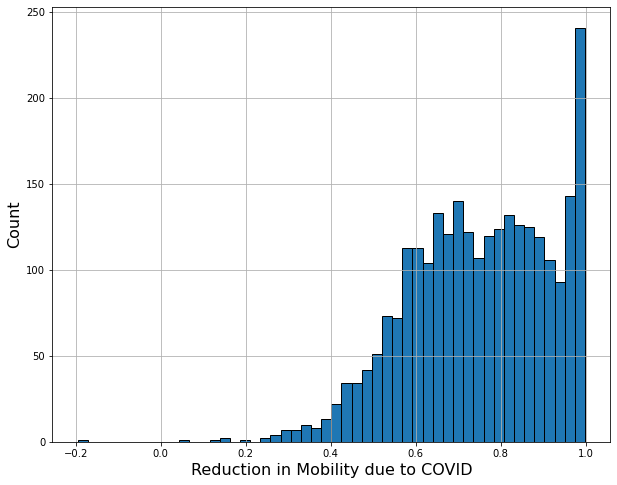

In [97]:
plot_metric(df_mob_spend_red,'Pct_Red_rolling_mean_mob','Reduction in Mobility due to COVID')

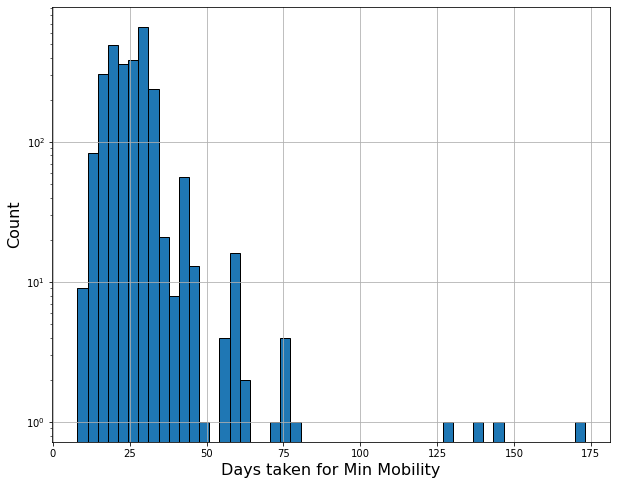

In [98]:
plot_metric(df_mob_spend_red,'Drop_days_rolling_mean_mob','Days taken for Min Mobility')
plt.yscale('log')

In [46]:
# df_merged = pd.merge(left = df_mobility, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
# df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
# df_merged.corr()

In [99]:
df_covid_case_mean = pd.DataFrame(columns=['fips','mean_case_rate' ])
for fips in df_mob_spend_red.fips.unique():
    date_thr = df_mob_spend_red[df_mob_spend_red.fips==fips]['min_date_rolling_mean_mob'].values[0]
    mean_case_rate = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date<=date_thr)]['Daily_cases'].mean()
    df_covid_case_mean = df_covid_case_mean.append({'fips':fips,'mean_case_rate':mean_case_rate},ignore_index=True)
df_covid_case_mean

,fips,mean_case_rate
0,01001,0.414634
1,01003,1.651163
2,01005,0.312500
3,01007,0.372093
4,01009,0.302326
...,...,...
2662,56033,0.260870
2663,56035,0.027027
2664,56037,0.212766
2665,56039,1.081081


In [100]:
def get_model_df(df_mob_spend_red,df_covid_case_mean,df_county_demo):
    df_model = df_mob_spend_red.join(df_covid_case_mean.set_index('fips'), on='fips')
    df_model = df_model.join(df_county_demo.set_index('fips'), on ='fips')
    return df_model

In [102]:
df_model = get_model_df(df_mob_spend_red,df_covid_case_mean,df_county_demo)

In [103]:
df_model.corr()['Drop_days_rolling_mean_mob'][df_model.corr()['rolling_mean_mob']>0.2]

rolling_mean_mob                                                                     0.031555
Min_rolling_mean_mob                                                                 0.104150
Race_Black or African American alone                                                 0.057893
Means of Transportation to Work_Car, truck, or van                                  -0.120957
Means of Transportation to Work_Car, truck, or van Drove alone                      -0.142026
Travel Time to Work_30 to 34 minutes                                                -0.035275
Travel Time to Work_35 to 39 minutes                                                -0.056671
Travel Time to Work_40 to 44 minutes                                                -0.070852
Travel Time to Work_45 to 59 minutes                                                -0.006511
Travel Time to Work_60 to 89 minutes                                                 0.043251
Employment Status for the Population 16 Years and Over_Not i

In [113]:
def run_model(df,df_source,name,task_type='GPU',max_depth= 6):
    
    target_var = ['Pct_Red_rolling_mean_mob']
    keep_cols = ['Pct_Red_rolling_mean_mob', 'rolling_mean_mob']
    remove_cols = ['fips', 'YEAR','COUNTY','NAME_E' ] + [col for col in df_source.columns if col not in keep_cols]
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth,devices='0',learning_rate=0.3,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 0.1408810	total: 47.1ms	remaining: 47.1s
200:	learn: 0.0075229	total: 8.3s	remaining: 33s
400:	learn: 0.0018230	total: 16.7s	remaining: 25s
600:	learn: 0.0006170	total: 24.9s	remaining: 16.5s
800:	learn: 0.0002160	total: 33s	remaining: 8.21s
999:	learn: 0.0000867	total: 41.1s	remaining: 0us
0.71


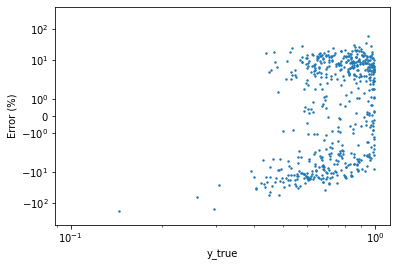

,Pre_Covid_Feature_Importance
Norm_Drop_Rate_rolling_mean_mob,25.304028
STATE,12.167977
pct_republican,3.473989
"Means of Transportation to Work_Car, truck, or van Drove alone",2.541726
party,2.097534
mean_case_rate,1.880220
rolling_mean_mob,1.787005
Median Household Income in the Past 12 Months (in 2018 Inflation-Adjusted Dollars)_Median household income in the past 12 months (in 2018 inflation-adjusted dollars),1.490037
"Household Income in the Past 12 Months (in 2018 Inflation-Adjusted Dollars)_Less than $10,000",1.422453
Means of Transportation to Work_Walked,1.420958


In [114]:
df_model_fi,y_test,y_pred_cb = run_model(df_model,df_mob_spend_red,name = 'Pre', task_type='CPU',max_depth = 7)
df_model_fi.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]